In [1]:
import sqlite3
import pandas as pd

In [2]:
conn = sqlite3.connect('/Users/cenkerarin/Desktop/Database/sqlite-sakila.db')

----
practice questions

## Q1: Show all data

In [3]:
df = pd.read_sql_query("SELECT * FROM rental", conn)
print(df.head())

   rental_id              rental_date  inventory_id  customer_id  \
0          1  2005-05-24 22:53:30.000           367          130   
1          2  2005-05-24 22:54:33.000          1525          459   
2          3  2005-05-24 23:03:39.000          1711          408   
3          4  2005-05-24 23:04:41.000          2452          333   
4          5  2005-05-24 23:05:21.000          2079          222   

               return_date  staff_id          last_update  
0  2005-05-26 22:04:30.000         1  2021-03-06 15:53:41  
1  2005-05-28 19:40:33.000         1  2021-03-06 15:53:41  
2  2005-06-01 22:12:39.000         1  2021-03-06 15:53:41  
3  2005-06-03 01:43:41.000         2  2021-03-06 15:53:41  
4  2005-06-02 04:33:21.000         1  2021-03-06 15:53:41  


## Q2: List the actors in each film

sql version:

In [4]:
query = """
SELECT film.title, actor.first_name, actor.last_name
FROM film 
JOIN film_actor ON film.film_id = film_actor.film_id
JOIN actor  ON film_actor.actor_id = actor.actor_id
"""
df = pd.read_sql_query(query, conn)
print(df.head())

                   title first_name last_name
0       ACADEMY DINOSAUR   PENELOPE   GUINESS
1   ANACONDA CONFESSIONS   PENELOPE   GUINESS
2            ANGELS LIFE   PENELOPE   GUINESS
3  BULWORTH COMMANDMENTS   PENELOPE   GUINESS
4          CHEAPER CLYDE   PENELOPE   GUINESS


python version:

In [5]:
film_df = pd.read_sql_query("SELECT * FROM film", conn)
film_actor_df = pd.read_sql_query("SELECT * FROM film_actor", conn)
actor_df = pd.read_sql_query("SELECT * FROM actor", conn)

In [6]:
merged_df = pd.merge(film_df, film_actor_df, on='film_id')
merged_df = pd.merge(merged_df, actor_df, on='actor_id')

In [7]:
result_df = merged_df[['title', 'first_name', 'last_name']]
print(result_df.head())

              title first_name last_name
0  ACADEMY DINOSAUR   PENELOPE   GUINESS
1  ACADEMY DINOSAUR  CHRISTIAN     GABLE
2  ACADEMY DINOSAUR    LUCILLE     TRACY
3  ACADEMY DINOSAUR     SANDRA      PECK
4  ACADEMY DINOSAUR     JOHNNY      CAGE


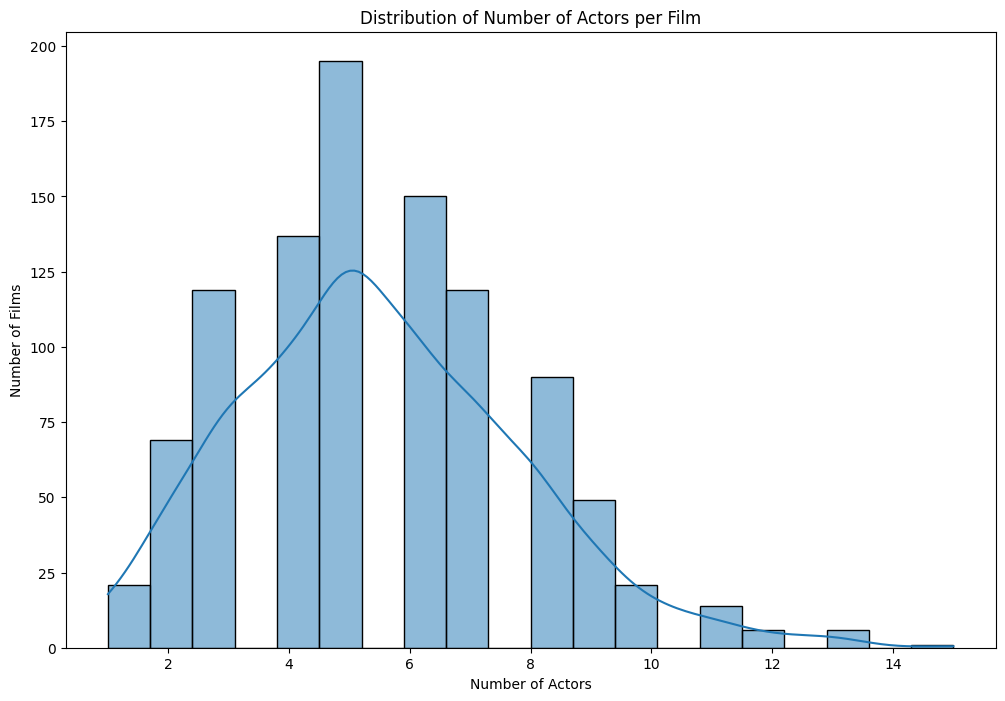

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

actors_per_film = result_df.groupby('title').size().reset_index(name='actor_count')

plt.figure(figsize=(12, 8))
sns.histplot(data=actors_per_film, x='actor_count', bins=20, kde=True)
plt.title('Distribution of Number of Actors per Film')
plt.xlabel('Number of Actors')
plt.ylabel('Number of Films')
plt.show()

## Q3: How many actors starred in each film?

sql version:

In [9]:
query = """
SELECT film.title, COUNT(film_actor.actor_id) AS actor_count
FROM film
JOIN film_actor ON film.film_id = film_actor.film_id
JOIN actor ON film_actor.actor_id = actor.actor_id
GROUP BY film.film_id
"""
df = pd.read_sql_query(query, conn)
print(df.head())

              title  actor_count
0  ACADEMY DINOSAUR           10
1    ACE GOLDFINGER            4
2  ADAPTATION HOLES            5
3  AFFAIR PREJUDICE            5
4       AFRICAN EGG            5


python version:

In [10]:
python_df = merged_df.groupby(['film_id', 'title']).size().reset_index(name='actor_count')
python_df = python_df[['title', 'actor_count']]
print(python_df.head())

              title  actor_count
0  ACADEMY DINOSAUR           10
1    ACE GOLDFINGER            4
2  ADAPTATION HOLES            5
3  AFFAIR PREJUDICE            5
4       AFRICAN EGG            5


## Q4: How many films does each actor have?

sql version:

In [11]:
query = """
SELECT actor.first_name, actor.last_name, COUNT(film_actor.film_id) AS movie_count
FROM actor
JOIN film_actor ON actor.actor_id = film_actor.actor_id
JOIN film ON film_actor.film_id = film.film_id
GROUP BY actor.first_name, actor.last_name
"""
df = pd.read_sql_query(query, conn)
print(df.tail())

    first_name last_name  movie_count
194       WILL    WILSON           31
195    WILLIAM   HACKMAN           27
196      WOODY   HOFFMAN           31
197      WOODY     JOLIE           31
198       ZERO      CAGE           25


python version:

In [ ]:
python_df = merged_df.groupby(['first_name', 'last_name']).size().reset_index(name='movie_count')
python_df = python_df[['first_name', 'last_name', 'movie_count']]
print(python_df.tail())

    first_name last_name  movie_count
194       WILL    WILSON           31
195    WILLIAM   HACKMAN           27
196      WOODY   HOFFMAN           31
197      WOODY     JOLIE           31
198       ZERO      CAGE           25


## Q5: Do we have any films that are not in the inventory and if we do, How many?

sql version:

In [13]:
query = """
SELECT COUNT(*) AS not_in_inventory
FROM film
WHERE film_id NOT IN (SELECT DISTINCT film_id FROM inventory)
"""
df = pd.read_sql_query(query, conn)
print(df.head())

   not_in_inventory
0                42


python version:

In [4]:
inventory_df = pd.read_sql_query("SELECT * FROM inventory", conn)
film_df = pd.read_sql_query("SELECT * FROM film", conn)

inventory_film_ids = inventory_df['film_id'].unique()

films_not_in_inventory = film_df[~film_df['film_id'].isin(inventory_film_ids)]

not_in_inventory_count = len(films_not_in_inventory)

print(f"Films not in inventory: {not_in_inventory_count}")


Films not in inventory: 42


## Q6: Show how many times that a rentable film got rented and their return

sql version:

In [15]:
query = """
SELECT film.title, COUNT(rental.rental_id) AS rental_count, SUM(payment.amount) AS total_revenue
FROM film
JOIN inventory ON film.film_id = inventory.film_id
JOIN rental ON inventory.inventory_id = rental.inventory_id
JOIN payment ON rental.rental_id = payment.rental_id
GROUP BY film.film_id
"""
df = pd.read_sql_query(query, conn)
print(df.head())

              title  rental_count  total_revenue
0  ACADEMY DINOSAUR            23          36.77
1    ACE GOLDFINGER             7          52.93
2  ADAPTATION HOLES            12          37.88
3  AFFAIR PREJUDICE            23          91.77
4       AFRICAN EGG            12          51.88


python version:

In [5]:
inventory_df = pd.read_sql_query("SELECT * FROM inventory", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)
payment_df = pd.read_sql_query("SELECT * FROM payment", conn)
film_df = pd.read_sql_query("SELECT * FROM film", conn)

In [ ]:
film_inventory = film_df.merge(inventory_df, on="film_id", how="inner")

film_inventory_rental = film_inventory.merge(rental_df, on="inventory_id", how="inner")

film_inventory_rental = film_inventory_rental.drop(columns=["last_update"], errors="ignore")
payment_df = payment_df.drop(columns=["last_update"], errors="ignore")

film_inventory_rental_payment = film_inventory_rental.merge(payment_df, on="rental_id", how="inner")

film_inventory_rental cols: ['film_id', 'title', 'description', 'release_year', 'language_id', 'original_language_id', 'rental_duration', 'rental_rate', 'length', 'replacement_cost', 'rating', 'special_features', 'last_update_x', 'inventory_id', 'store_id', 'last_update_y', 'rental_id', 'rental_date', 'customer_id', 'return_date', 'staff_id']
payment_df cols: ['payment_id', 'customer_id', 'staff_id', 'rental_id', 'amount', 'payment_date']


In [ ]:
result = (
    film_inventory_rental_payment
    .groupby(["title"])
    .agg(
        rental_count=("rental_id", "count"),
        total_revenue=("amount", "sum")
    )
    .reset_index()
)

print(result.head())

              title  rental_count  total_revenue
0  ACADEMY DINOSAUR            23          36.77
1    ACE GOLDFINGER             7          52.93
2  ADAPTATION HOLES            12          37.88
3  AFFAIR PREJUDICE            23          91.77
4       AFRICAN EGG            12          51.88


## Q7: Show the rental_rate of the movies that are not in the inventory

sql version:

In [14]:
query = """
SELECT film.title, film.rental_rate
FROM film
WHERE film_id NOT IN (SELECT DISTINCT film_id FROM inventory)
"""
df = pd.read_sql_query(query, conn)
print(df.head())
print(len(df))

                  title  rental_rate
0        ALICE FANTASIA         0.99
1           APOLLO TEEN         2.99
2        ARGONAUTS TOWN         0.99
3         ARK RIDGEMONT         0.99
4  ARSENIC INDEPENDENCE         0.99
42


python version:

In [ ]:
film_df = pd.read_sql_query("SELECT * FROM film", conn)
inventory_df = pd.read_sql_query("SELECT * FROM inventory", conn)

In [ ]:
inventory_film_ids = inventory_df['film_id'].unique()

films_not_in_inventory = film_df[~film_df['film_id'].isin(inventory_film_ids)]

result = films_not_in_inventory[['title', 'rental_rate']]

print(result.head())
print(len(result))

                   title  rental_rate
13        ALICE FANTASIA         0.99
32           APOLLO TEEN         2.99
35        ARGONAUTS TOWN         0.99
37         ARK RIDGEMONT         0.99
40  ARSENIC INDEPENDENCE         0.99
42


## Q8: How many customers have not returned multiple DVDs?

sql version:

In [3]:
query = """
SELECT COUNT(DISTINCT customer_id) AS customer_count
FROM rental
WHERE return_date IS NULL
GROUP BY customer_id
HAVING COUNT(rental_id) > 1
"""
df = pd.read_sql_query(query, conn)
print(len(df))

23


python version:

In [4]:
customer_df = pd.read_sql_query("SELECT * FROM customer", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)

customer_rental = customer_df.merge(rental_df, on="customer_id", how="inner")

aktifler = customer_rental[customer_rental['return_date'].isna()]

sayılar = aktifler.groupby("customer_id")['rental_id'].count()

customer_count = (sayılar > 1).sum()

print(customer_count)

23


## Q9: every customers film rental counts

sql version:

In [5]:
query = """
SELECT customer.first_name, customer.last_name, COUNT(rental.rental_id) AS rental_count
FROM customer
JOIN rental ON customer.customer_id = rental.customer_id
GROUP BY customer.first_name, customer.last_name
"""
df = pd.read_sql_query(query, conn)
print(df.head())

  first_name last_name  rental_count
0      AARON     SELBY            24
1       ADAM     GOOCH            22
2     ADRIAN     CLARY            19
3      AGNES    BISHOP            23
4       ALAN      KAHN            26


python version:

In [ ]:
customer_df = pd.read_sql_query("SELECT * FROM customer", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)

customer_rental = customer_df.merge(rental_df, on="customer_id", how="inner")

customer_rental_count = customer_rental.groupby(["first_name", "last_name"])["rental_id"].count()

customer_rental_count = customer_rental_count.reset_index(name="rental_count")

print(customer_rental_count.head())

first_name  last_name
AARON       SELBY        24
ADAM        GOOCH        22
ADRIAN      CLARY        19
AGNES       BISHOP       23
ALAN        KAHN         26
Name: rental_id, dtype: int64


## Q10: Most rented films and how much revenue they got

sql version:

In [12]:
query = """
SELECT category.name AS genre, film.title, COUNT(rental.rental_id) AS rental_count, SUM(payment.amount) AS total_revenue
FROM category
JOIN film_category ON category.category_id = film_category.category_id
JOIN film ON film_category.film_id = film.film_id
JOIN inventory ON film.film_id = inventory.film_id
JOIN rental ON inventory.inventory_id = rental.inventory_id
JOIN payment ON rental.rental_id = payment.rental_id
GROUP BY category.name, film.title
ORDER BY rental_count DESC;
"""
df = pd.read_sql_query(query, conn)
print(df.head())

       genre               title  rental_count  total_revenue
0     Travel  BUCKET BROTHERHOOD            34         180.66
1    Foreign    ROCKETEER MOTHER            33         116.67
2  Animation      JUGGLER HARDLY            32          96.68
3      Games      FORWARD TEMPLE            32         128.68
4      Games      GRIT CLOCKWORK            32         110.68


python version:

In [41]:
film_df = pd.read_sql_query("SELECT * FROM film", conn)
category_df = pd.read_sql_query("SELECT * FROM category", conn)
film_category_df = pd.read_sql_query("SELECT * FROM film_category", conn)
inventory_df = pd.read_sql_query("SELECT * FROM inventory", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)
payment_df = pd.read_sql_query("SELECT * FROM payment", conn)

dropping_list = (film_df, category_df, film_category_df, inventory_df, rental_df, payment_df)

for df in dropping_list:
    if 'last_update' in df.columns:
        df.drop('last_update', axis=1, inplace=True)

In [42]:
category_film = category_df.merge(film_category_df, on="category_id", how="inner")
category_film_full = category_film.merge(film_df, on="film_id", how="inner")
category_film_inventory = category_film_full.merge(inventory_df, on="film_id", how="inner")
category_film_rental = category_film_inventory.merge(rental_df, on="inventory_id", how="inner")
category_film_payment = category_film_rental.merge(payment_df, on="rental_id", how="inner")

df = category_film_payment.groupby(['name', 'title']).agg({
    'rental_id': 'count',
    'amount': 'sum'
}).reset_index()

df.columns = ['genre', 'title', 'rental_count', 'total_revenue']

df = df.sort_values('rental_count', ascending=False)

print(df.head())


         genre                title  rental_count  total_revenue
909     Travel   BUCKET BROTHERHOOD            34         180.66
536    Foreign     ROCKETEER MOTHER            33         116.67
757        New  RIDGEMONT SUBMARINE            32         130.68
572      Games       GRIT CLOCKWORK            32         110.68
93   Animation       JUGGLER HARDLY            32          96.68


## Q11: Rent and Revenue count based on genre and date 

### sql version

In [3]:
query = """
SELECT category.name AS genre, DATE(rental.rental_date) AS rental_date, COUNT(rental.rental_id) AS rental_count, SUM(payment.amount) AS total_revenue
FROM category
JOIN film_category ON category.category_id = film_category.category_id
JOIN film ON film_category.film_id = film.film_id
JOIN inventory ON film.film_id = inventory.film_id
JOIN rental ON inventory.inventory_id = rental.inventory_id
JOIN payment ON rental.rental_id = payment.rental_id
GROUP BY genre, rental_date
ORDER BY rental_date;
"""
df = pd.read_sql_query(query, conn)
print(df.head())

       genre rental_date  rental_count  total_revenue
0  Animation  2005-05-24             1           4.99
1   Children  2005-05-24             1           3.99
2   Children  2005-05-24             1           6.99
3     Comedy  2005-05-24             1           0.99
4     Family  2005-05-24             1           2.99


### python version

In [4]:
category_df = pd.read_sql_query("SELECT * FROM category", conn)
film_category_df = pd.read_sql_query("SELECT * FROM film_category", conn)
film_df = pd.read_sql_query("SELECT * FROM film", conn)
inventory_df = pd.read_sql_query("SELECT * FROM inventory", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)
payment_df = pd.read_sql_query("SELECT * FROM payment", conn)

dropping_list = (film_df, category_df, film_category_df, inventory_df, rental_df, payment_df)

for df in dropping_list:
    if 'last_update' in df.columns:
        df.drop('last_update', axis=1, inplace=True)

In [9]:
fcc = film_category_df.merge(category_df, on="category_id", how="inner")
fccf = fcc.merge(film_df, on="film_id", how="inner")
fccfi = fccf.merge(inventory_df, on="film_id", how="inner")
fccfir = fccfi.merge(rental_df, on="inventory_id", how="inner")
fccfirr = fccfir.merge(payment_df, on="rental_id", how="inner")

df = fccfirr.groupby(['name', 'rental_date']).agg({
    'rental_id': 'count',
    'amount': 'sum'
}).reset_index()

df.columns = ['genre', 'rental_date', 'rental_count', 'total_revenue']

print(df.head())

    genre              rental_date  rental_count  total_revenue
0  Action  2005-05-25 03:41:50.000             1           4.99
1  Action  2005-05-25 05:09:04.000             1           4.99
2  Action  2005-05-25 08:26:13.000             1           2.99
3  Action  2005-05-25 09:01:57.000             1           5.99
4  Action  2005-05-25 11:31:59.000             1           0.99


## Q12: Rent count for rentable movies, ordered by genre

### sql version

In [10]:
query = """
SELECT category.name AS genre, film.title, COUNT(rental.rental_id) AS rental_count
FROM category
JOIN film_category ON category.category_id = film_category.category_id
JOIN film ON film_category.film_id = film.film_id
JOIN inventory ON film.film_id = inventory.film_id
JOIN rental ON inventory.inventory_id = rental.inventory_id
GROUP BY genre, film.title;
"""

df = pd.read_sql_query(query, conn)
print(df.head())

    genre                title  rental_count
0  Action         AMADEUS HOLY            21
1  Action      AMERICAN CIRCUS            22
2  Action   ANTITRUST TOMATOES            10
3  Action  BAREFOOT MANCHURIAN            18
4  Action         BERETS AGENT            21


### python version

In [ ]:
category_df = pd.read_sql_query("SELECT * FROM category", conn)
film_category_df = pd.read_sql_query("SELECT * FROM film_category", conn)
film_df = pd.read_sql_query("SELECT * FROM film", conn)
inventory_df = pd.read_sql_query("SELECT * FROM inventory", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)

dropping_list = (film_df, category_df, film_category_df, inventory_df, rental_df, payment_df)

for df in dropping_list:
    if 'last_update' in df.columns:
        df.drop('last_update', axis=1, inplace=True)

In [21]:
fcc = film_category_df.merge(category_df, on="category_id", how="inner")
fccf = fcc.merge(film_df, on="film_id", how="inner")
fccfi = fccf.merge(inventory_df, on="film_id", how="inner")
fccfir = fccfi.merge(rental_df, on="inventory_id", how="inner")

df = fccfir.groupby(['name', 'title']).agg({
    'rental_id': 'count'
}).reset_index()

df.columns = ['genre', 'title', 'rental_count']

df = df.sort_values('genre')
print(df.head())

     genre               title  rental_count
0   Action        AMADEUS HOLY            21
33  Action        LORD ARIZONA            11
34  Action           LUST LOCK            15
35  Action  MAGNOLIA FORRESTER            11
36  Action   MIDNIGHT WESTWARD            17


## Q13: Most films on hold

### sql version

In [22]:
query = """
SELECT film.title, DATE('now') - rental.rental_date AS days_on_shelf
FROM film
JOIN inventory ON film.film_id = inventory.film_id
JOIN rental ON inventory.inventory_id = rental.inventory_id
WHERE rental.return_date IS NULL
ORDER BY days_on_shelf DESC;
"""

df = pd.read_sql_query(query, conn)
print(df.head())


              title  days_on_shelf
0  ACADEMY DINOSAUR             20
1       HYDE DOCTOR             19
2       HUNGER ROOF             19
3    FRISCO FORREST             19
4       TITANS JERK             19


### python version

In [23]:
film_df = pd.read_sql_query("SELECT * FROM film", conn)
inventory_df = pd.read_sql_query("SELECT * FROM inventory", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)

dropping_list = (film_df, category_df, film_category_df, inventory_df, rental_df, payment_df)

for df in dropping_list:
    if 'last_update' in df.columns:
        df.drop('last_update', axis=1, inplace=True)

In [ ]:
from datetime import date

film_inventory = film_df.merge(inventory_df, on="film_id", how="inner")
film_inventory_rental = film_inventory.merge(rental_df, on="inventory_id", how="inner")

current_rentals = film_inventory_rental[film_inventory_rental['return_date'].isnull()]

today = pd.to_datetime(date.today())
current_rentals['days_on_shelf'] = (today - pd.to_datetime(current_rentals['rental_date']).dt.normalize()).dt.days

result = current_rentals[['title', 'days_on_shelf']]
print(result.head())

                title  days_on_shelf
16   ACADEMY DINOSAUR           7341
24     ACE GOLDFINGER           7164
61   AFFAIR PREJUDICE           7164
76        AFRICAN EGG           7164
224       ALI FOREVER           7164


/var/folders/sd/mp8h6dhx24d94wlc3ddbb2500000gn/T/ipykernel_41290/1074856928.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_rentals['days_on_shelf'] = (today - pd.to_datetime(current_rentals['rental_date']).dt.normalize()).dt.days


## Q14: Show late, early and correctly timed returns on rented movies

### sql version

In [31]:
query = """
SELECT
    SUM(CASE WHEN return_date > due_date THEN 1 ELSE 0 END) AS late_returns,
    SUM(CASE WHEN return_date < due_date THEN 1 ELSE 0 END) AS early_returns,
    SUM(CASE WHEN return_date = due_date THEN 1 ELSE 0 END) AS on_time_returns
FROM rental;
"""

df = pd.read_sql_query(query, conn)
print(df.head())

DatabaseError: Execution failed on sql '
SELECT
    SUM(CASE WHEN return_date > due_date THEN 1 ELSE 0 END) AS late_returns,
    SUM(CASE WHEN return_date < due_date THEN 1 ELSE 0 END) AS early_returns,
    SUM(CASE WHEN return_date = due_date THEN 1 ELSE 0 END) AS on_time_returns
FROM rental;
': no such column: due_date

### python version

In [32]:
# this q has errors

## Q15: Which customer rented most DVD's

### sql version

In [33]:
query = """
SELECT customer.first_name, customer.last_name, COUNT(rental.rental_id) AS rental_count
FROM customer
JOIN rental ON customer.customer_id = rental.customer_id
GROUP BY customer.customer_id
ORDER BY rental_count DESC
LIMIT 1;
"""

df = pd.read_sql_query(query, conn)
print(df.head())

  first_name last_name  rental_count
0    ELEANOR      HUNT            46


### python version

In [ ]:
customer_df = pd.read_sql_query("SELECT * FROM customer", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)

customer_rental = customer_df.merge(rental_df, on="customer_id", how="inner")

cr_count = customer_rental.groupby(['first_name', 'last_name'])

cr_count = cr_count.size().reset_index(name='rental_count')

cr_count = cr_count.sort_values('rental_count', ascending=False)

print(cr_count.head(1))

    first_name last_name  rental_count
175    ELEANOR      HUNT            46


In [45]:
customer_df = pd.read_sql_query("SELECT * FROM customer", conn)
rental_df = pd.read_sql_query("SELECT * FROM rental", conn)

customer_rental = customer_df.merge(rental_df, on="customer_id", how="inner")

df = customer_rental.groupby(['first_name', 'last_name']).agg({
    'rental_id': 'count'
}).reset_index()

df.columns = ['first_name', 'last_name', 'rental_count']

df.sort_values('rental_count', ascending=False).head(1)

,first_name,last_name,rental_count
175,ELEANOR,HUNT,46
